In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import pathlib

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from numba import jit, prange

In [4]:
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [5]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [6]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [7]:
locations.head()

,0,1
0,42.63914,141.62366
1,36.42835,140.61340
2,42.63864,141.62542
3,36.42911,140.61360
4,36.42957,140.61429


In [8]:
locations.max()

0     78.93490
1    179.82728
dtype: float64

In [9]:
locations.columns = ["lat", "lon"]
locations["phi"] = locations["lat"] * np.pi / 180
locations["lambda"] = locations["lon"] * np.pi / 180

In [10]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494055 entries, 0 to 1494054
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   lat     1494055 non-null  float64
 1   lon     1494055 non-null  float64
 2   phi     1494055 non-null  float64
 3   lambda  1494055 non-null  float64
dtypes: float64(4)
memory usage: 45.6 MB


In [11]:
locations = locations.sort_values(by="lon")

In [12]:
locs = gpd.GeoDataFrame(locations,
                        geometry=gpd.points_from_xy(locations["lon"], locations["lat"]))

In [13]:
def measure_time(df, f, ns=np.logspace(9, 14, 6, base=2)):
    """Measure timings for distance function `f`."""

    timings = {}

    for num in ns:
        sample = df.sample(int(num), replace=False)
        v = sample.values
        start_ts = time.time()
        distances = f(v)
        end_ts = time.time()
        timings[num] = end_ts - start_ts
    return pd.Series(timings)

# Intermezzo on Pandas and NumPy

For Pandas dataframes, `.values` should be used with caution. Although transparent when you're on the Python side of things, of when you do not do slicing or sorting, this can lead to a severe side effects when using Numba. Consider this:

In [14]:
locations.loc[:100, ["phi", "lambda"]].values

array([[ 1.15742085, -3.12610355],
       [ 1.15742295, -3.12610129],
       [ 1.15741352, -3.12609849],
       ...,
       [ 0.63578191,  2.45417605],
       [ 0.63579971,  2.45417623],
       [ 0.63577842,  2.45417745]])

Looks like a normal NumPy array, although it's a tricky one:

In [15]:
locations.loc[:100, ["phi", "lambda"]].values.strides

(8, 11573080)

As you can see, it's F-order (!) with a huge stride over axis 1. This has two consequences:

- Numba may produce any upredictable segfault on this (as it tries to treat this a plain C-array),
- this will be extremely inefficient.

This all is caused by using `.loc`. Compare it to:

In [16]:
locations.iloc[:100][["phi", "lambda"]].values.strides

(8, 800)

Still F-order, but not it's not trying to jump over the entire non-sliced array. Also, to benefit from sorting, we have to use `.iloc`, not `.loc`, as `.loc` is label-based and doesn't respect the ordering we created.

# Connectivity/distance matrix

In [17]:
R0 = 6378.1

@jit(parallel=True)
def haversine_distances_parallel(d):
    """Numba version of haversine distance."""

    dist_mat = np.zeros((d.shape[0], d.shape[0]))

    # We parallelize outer loop to keep threads busy
    for i in prange(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            sin_0 = np.sin(0.5 * (d[i, 0] - d[j, 0]))
            sin_1 = np.sin(0.5 * (d[i, 1] - d[j, 1]))
            cos_0 = np.cos(d[i, 0]) * np.cos(d[j, 0])
            dist_mat[i, j] = 2 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))
            dist_mat[j, i] = dist_mat[i, j]
    return R0 * dist_mat


@jit
def longitude_distance(x1, x2):
    """Numba version of logitude distance."""

    return R0 * np.abs(x1 - x2)


@jit
def haversine_distance(x1, y1, x2, y2):
    """Single pair Numba version of haversine distance."""

    sin_0 = np.sin(0.5 * (x1 - x2))
    sin_1 = np.sin(0.5 * (y1 - y2))
    cos_0 = np.cos(x1) * np.cos(y1)
    return 2 * R0 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))


@jit
def get_ci(d, thr):
    """Calculate connectivity indices in a JIT-compiled way."""

    lpairs = []
    rpairs = []

    for i in range(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            distance = haversine_distance(d[i, 0], d[i, 1], d[j, 0], d[j, 1])
            lon_distance = longitude_distance(d[i, 1], d[j, 1])

            if distance <= thr:
                lpairs.extend([i, j])
                rpairs.extend([j, i])
            if lon_distance > thr:
                break
    return np.array(lpairs), np.array(rpairs)


def get_haversine_distance(coords, phi_col="phi", lambda_col="lambda"):
    """Calculate connectivity matrix."""

    coords_raw = np.array(coords[[phi_col, lambda_col]], order="C")

    return haversine_distances_parallel(coords_raw)


def get_connectivity_matrix(coords, distance_thr, phi_col="phi", lambda_col="lambda"):
    """Calculate connectivity matrix."""

    coords_raw = np.array(coords[[phi_col, lambda_col]], order="C")

    lpairs, rpairs = get_ci(coords_raw, distance_thr)
    return csr_matrix((np.ones(len(lpairs), dtype=np.int8), (lpairs, rpairs)),
                      shape=(coords.shape[0], coords.shape[0]),
                      dtype=np.int8)

In [18]:
locs

,lat,lon,phi,lambda,geometry
35097,66.31533,-179.11254,1.157421,-3.126104,POINT (-179.11254 66.31533)
1318033,66.31545,-179.11241,1.157423,-3.126101,POINT (-179.11241 66.31545)
1490188,66.31491,-179.11225,1.157414,-3.126098,POINT (-179.11225 66.31491)
1483607,66.31232,-179.10682,1.157368,-3.126004,POINT (-179.10682 66.31232)
62040,66.31465,-179.10638,1.157409,-3.125996,POINT (-179.10638 66.31465)
...,...,...,...,...,...
1460858,-8.90093,179.50205,-0.155351,3.132902,POINT (179.50205 -8.90093)
1467242,-8.93008,179.59959,-0.155859,3.134604,POINT (179.59959 -8.93008)
1467243,-8.96719,179.60652,-0.156507,3.134725,POINT (179.60652 -8.96719)
1446459,63.51520,179.78127,1.108549,3.137775,POINT (179.78127 63.51520)


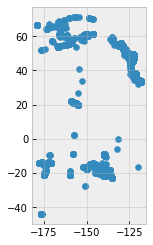

In [46]:
locs[:10000].plot()

In [19]:
# This one is ok
haversine_distances_parallel(locations.iloc[:10][["phi", "lambda"]].values)

array([[0.        , 0.01456834, 0.04851906, 0.42154935, 0.28567248,
        0.4905079 , 0.41178822, 0.51562784, 0.53827384, 0.58829147],
       [0.01456834, 0.        , 0.06053647, 0.42882806, 0.28397242,
        0.49462368, 0.4082286 , 0.51587251, 0.53370484, 0.5860334 ],
       [0.04851906, 0.06053647, 0.        , 0.37695171, 0.26408586,
        0.45182523, 0.3946384 , 0.48643648, 0.52366437, 0.56605245],
       [0.42154935, 0.42882806, 0.37695171, 0.        , 0.26011822,
        0.12737481, 0.31398202, 0.25147484, 0.40569176, 0.37002785],
       [0.28567248, 0.28397242, 0.26408586, 0.26011822, 0.        ,
        0.25630572, 0.13283599, 0.23658186, 0.26327992, 0.3028001 ],
       [0.4905079 , 0.49462368, 0.45182523, 0.12737481, 0.25630572,
        0.        , 0.2507937 , 0.1374534 , 0.30941213, 0.25406466],
       [0.41178822, 0.4082286 , 0.3946384 , 0.31398202, 0.13283599,
        0.2507937 , 0.        , 0.16061201, 0.13045633, 0.18273382],
       [0.51562784, 0.51587251, 0.4864364

In [20]:
# This one is definitely ok
get_haversine_distance(locations.iloc[:10])

array([[0.        , 0.01456834, 0.04851906, 0.42154935, 0.28567248,
        0.4905079 , 0.41178822, 0.51562784, 0.53827384, 0.58829147],
       [0.01456834, 0.        , 0.06053647, 0.42882806, 0.28397242,
        0.49462368, 0.4082286 , 0.51587251, 0.53370484, 0.5860334 ],
       [0.04851906, 0.06053647, 0.        , 0.37695171, 0.26408586,
        0.45182523, 0.3946384 , 0.48643648, 0.52366437, 0.56605245],
       [0.42154935, 0.42882806, 0.37695171, 0.        , 0.26011822,
        0.12737481, 0.31398202, 0.25147484, 0.40569176, 0.37002785],
       [0.28567248, 0.28397242, 0.26408586, 0.26011822, 0.        ,
        0.25630572, 0.13283599, 0.23658186, 0.26327992, 0.3028001 ],
       [0.4905079 , 0.49462368, 0.45182523, 0.12737481, 0.25630572,
        0.        , 0.2507937 , 0.1374534 , 0.30941213, 0.25406466],
       [0.41178822, 0.4082286 , 0.3946384 , 0.31398202, 0.13283599,
        0.2507937 , 0.        , 0.16061201, 0.13045633, 0.18273382],
       [0.51562784, 0.51587251, 0.4864364

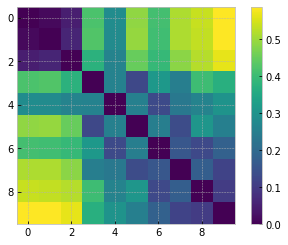

In [21]:
plt.imshow(get_haversine_distance(locations.iloc[:10]))
plt.colorbar()

In [22]:
%%timeit
haversine_distance(locations.iloc[0]["phi"], locations.iloc[0]["lambda"],
                   locations.iloc[1]["phi"], locations.iloc[1]["lambda"])

417 µs ± 6.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%timeit longitude_distance(locations.iloc[0]["lambda"], locations.iloc[1]["lambda"])

205 µs ± 7.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
%timeit get_connectivity_matrix(locations.iloc[:1000], 20)

7.31 ms ± 86.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit get_connectivity_matrix(locations.iloc[:10000], 20)

617 ms ± 5.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ok, we should expect about 6 seconds on 100K points and about a couple of minutes for entire dataset.

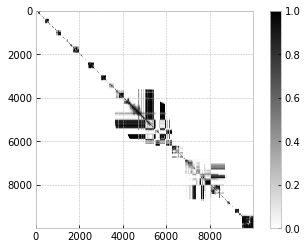

In [27]:
cm = get_connectivity_matrix(locations.iloc[:10000], 20)

plt.imshow(cm.toarray(), cmap=plt.cm.gray_r)
plt.colorbar()

# Validating the selected area

In [28]:
from shapely.geometry import box

In [29]:
Xc, Yc = 33, 33
D = 4

minx, miny, maxx, maxy = Xc - D, Yc - D, Xc + D, Yc + D
aoi = box(minx, miny, maxx, maxy)

In [30]:
aoi_locs = locs[locs.within(aoi)]

## Adding world map as a reference

In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

(29.0, 37.0)

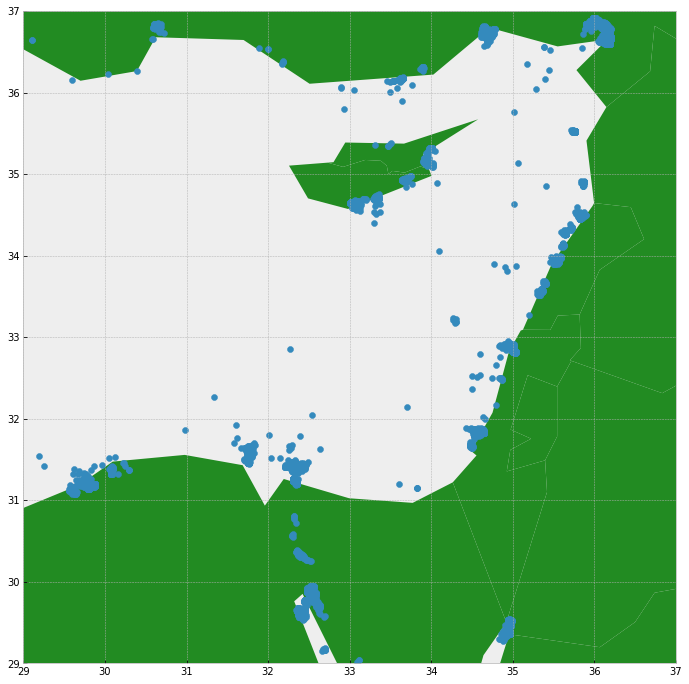

In [32]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs.plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

In [33]:
aoi_locs

,lat,lon,phi,lambda,geometry
328120,36.63841,29.10555,0.639461,0.507988,POINT (29.10555 36.63841)
1201659,36.64617,29.10850,0.639596,0.508039,POINT (29.10850 36.64617)
1101484,31.54833,29.18833,0.550622,0.509432,POINT (29.18833 31.54833)
1101485,31.42167,29.25333,0.548412,0.510567,POINT (29.25333 31.42167)
1038761,31.10833,29.55667,0.542943,0.515861,POINT (29.55667 31.10833)
...,...,...,...,...,...
761870,36.66454,36.20847,0.639917,0.631957,POINT (36.20847 36.66454)
271272,36.66438,36.20851,0.639914,0.631958,POINT (36.20851 36.66438)
408638,36.66509,36.20852,0.639927,0.631958,POINT (36.20852 36.66509)
45663,36.66367,36.20880,0.639902,0.631963,POINT (36.20880 36.66367)


In [34]:
get_haversine_distance(aoi_locs.iloc[:1000])

array([[0.00000000e+00, 9.03126909e-01, 5.66673131e+02, ...,
        6.11773885e+02, 6.10440110e+02, 6.10624690e+02],
       [9.03126909e-01, 0.00000000e+00, 5.67533297e+02, ...,
        6.12600056e+02, 6.11266190e+02, 6.11450777e+02],
       [5.66673131e+02, 5.67533297e+02, 0.00000000e+00, ...,
        7.69941109e+01, 7.62852393e+01, 7.63893217e+01],
       ...,
       [6.11773885e+02, 6.12600056e+02, 7.69941109e+01, ...,
        0.00000000e+00, 1.34250662e+00, 1.15776338e+00],
       [6.10440110e+02, 6.11266190e+02, 7.62852393e+01, ...,
        1.34250662e+00, 0.00000000e+00, 1.84987923e-01],
       [6.10624690e+02, 6.11450777e+02, 7.63893217e+01, ...,
        1.15776338e+00, 1.84987923e-01, 0.00000000e+00]])

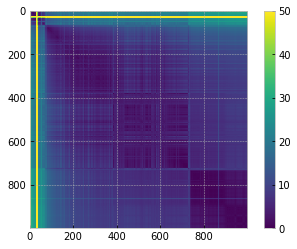

In [35]:
plt.imshow(get_haversine_distance(aoi_locs.iloc[:1000]), vmin=0, vmax=50)
plt.colorbar()

Distances look correct (estimate of max distance in the area is from Alexandria to Dörtyol, which is about 850 km).

# Connected components

In [36]:
THR = 20

In [37]:
cm = get_connectivity_matrix(aoi_locs[["phi", "lambda"]], THR)

In [38]:
cm

<18794x18794 sparse matrix of type '<class 'numpy.int8'>'
	with 25323122 stored elements in Compressed Sparse Row format>

In [54]:
cm.nnz // (1024 * 1024) # So, it's about 24 Mb

24

In [40]:
n_comp, components = connected_components(cm, directed=False)

In [41]:
n_comp

55

In [42]:
components

array([ 0,  0,  1, ..., 54, 54, 54], dtype=int32)

In [43]:
aoi_locs["component"] = components

<ipython-input-43-717bf75a6d90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoi_locs["component"] = components


In [44]:
aoi_locs.component.value_counts()

54    3015
37    2297
35    2157
34    1606
50    1432
15    1403
2     1369
11    1206
21    1003
40     770
9      747
30     525
6      370
26     264
47     160
14     132
24     104
51      97
52      34
29      23
18      12
12       7
33       7
23       6
38       4
19       3
48       3
22       3
46       3
10       3
28       3
1        2
0        2
49       1
8        1
31       1
32       1
20       1
36       1
5        1
45       1
3        1
13       1
44       1
53       1
16       1
43       1
27       1
7        1
42       1
17       1
39       1
41       1
4        1
25       1
Name: component, dtype: int64

(29.0, 37.0)

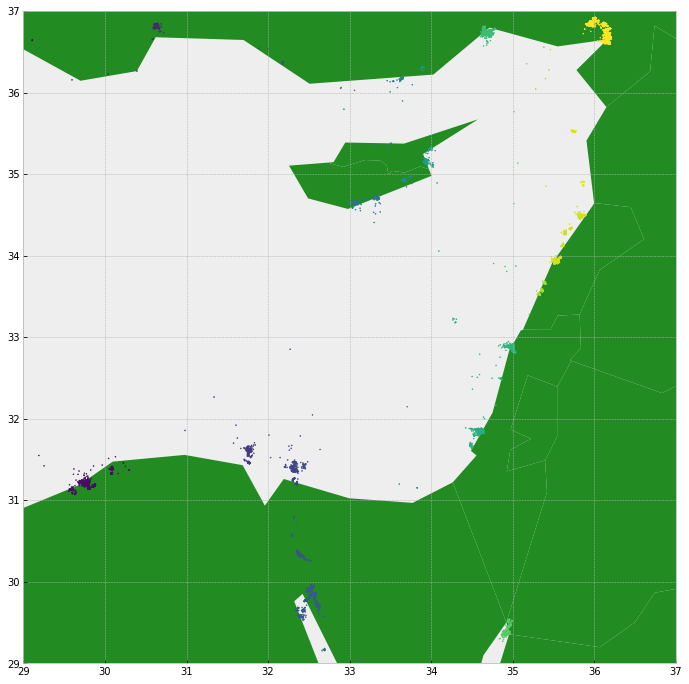

In [45]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs.plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

The largest connected component has about 3000 vessel activities, which is 6 times smaller compared to full area activites and dramatically smaller compared to full dataset (size of connected component in the area doesn't depend on whether we calculate full location dataframe or only part of it).

In [46]:
aoi_locs[aoi_locs.component==54]

,lat,lon,phi,lambda,geometry,component
965552,36.72285,35.86715,0.640935,0.626000,POINT (35.86715 36.72285),54
887955,36.77700,35.88183,0.641880,0.626256,POINT (35.88183 36.77700),54
887970,36.77817,35.88383,0.641900,0.626291,POINT (35.88383 36.77817),54
1399208,36.83780,35.90038,0.642941,0.626580,POINT (35.90038 36.83780),54
471427,36.83782,35.90066,0.642941,0.626585,POINT (35.90066 36.83782),54
...,...,...,...,...,...,...
761870,36.66454,36.20847,0.639917,0.631957,POINT (36.20847 36.66454),54
271272,36.66438,36.20851,0.639914,0.631958,POINT (36.20851 36.66438),54
408638,36.66509,36.20852,0.639927,0.631958,POINT (36.20852 36.66509),54
45663,36.66367,36.20880,0.639902,0.631963,POINT (36.20880 36.66367),54


(29.0, 37.0)

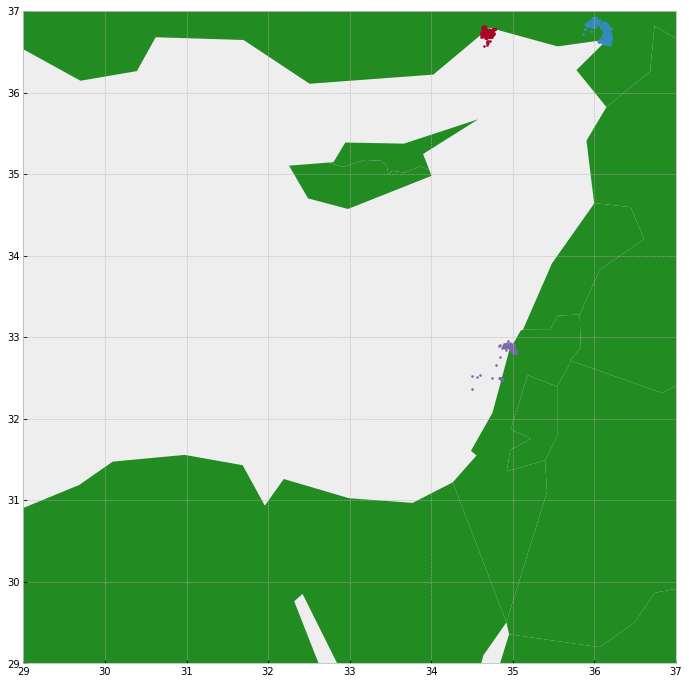

In [50]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs[aoi_locs.component==54].plot(ax=plt.gca(), markersize=4)
aoi_locs[aoi_locs.component==37].plot(ax=plt.gca(), markersize=4)
aoi_locs[aoi_locs.component==35].plot(ax=plt.gca(), markersize=4)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

Connected components also allow us to filter activities, not related spatially to others:

In [51]:
NUM_THR = 100

component_sizes = aoi_locs.component.value_counts()
large_components = component_sizes[component_sizes>NUM_THR].index

(29.0, 37.0)

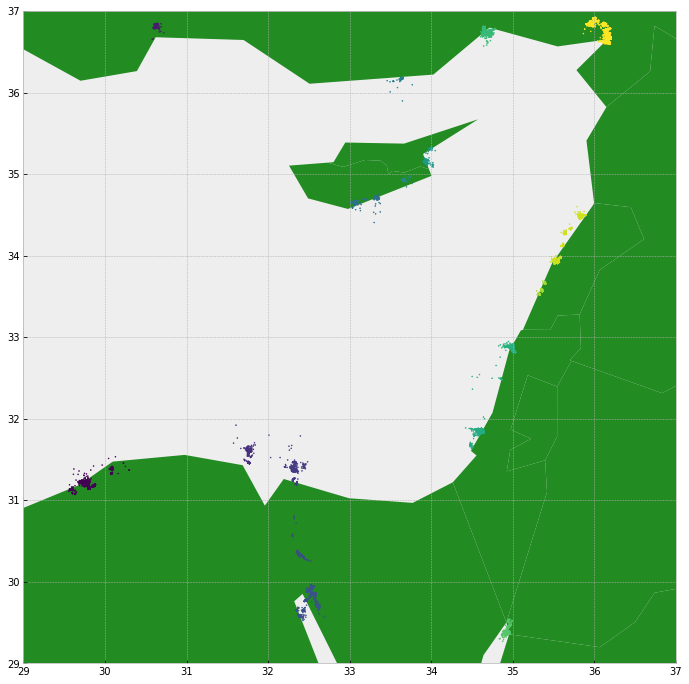

In [52]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs[aoi_locs.component.isin(large_components)].plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

This one doesn't contain vessels floating around in the sea anymore.

# Calculating the full connectivity matrix and connected components

In [ ]:
THR = 10

cm10 = get_connectivity_matrix(locs, distance_thr=THR)

In [ ]:
cm10.nbytes